In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [4]:
# print(os.listdir("D:/ML DATASET/output/train"))

SIZE = 256  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/MACHINE LEARNING/MLDataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label.split("/")[7])
print("completed")

/content/drive/MyDrive/MACHINE LEARNING/MLDataset/train/With Mask
/content/drive/MyDrive/MACHINE LEARNING/MLDataset/train/Without Mask
completed


In [5]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/MACHINE LEARNING/MLDataset/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label.split("/")[7])
print("completed")

completed


In [7]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [9]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [10]:
x_train.shape

(1758, 256, 256, 3)

In [11]:
y_train.shape

(1758,)

In [12]:
# Scale pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. Not needed for Random Forest
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
#Load VGG model with imagenet trained weights and without classifier/fully connected layers
#We will use this as feature extractor. 
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
#Now, let us extract features using VGG imagenet weights
#Train features
train_feature_extractor=VGG_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
#test features
test_feature_extractor=VGG_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

In [ ]:
train_features.shape

(1758, 32768)

In [ ]:
# Reduce dimensions using PCA
from sklearn.decomposition import PCA

In [ ]:
x_train.shape

(1758, 256, 256, 3)

Text(0, 0.5, 'Cum variance')

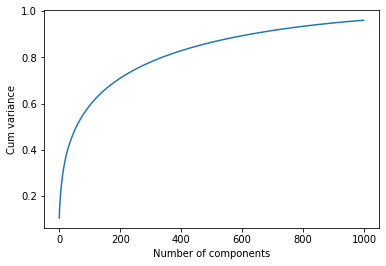

In [ ]:
#First verfiy the ideal number of PCA components to not lose much information. 
#Try to retain 90% information, so look where the curve starts to flatten.
#Remember that the n_components must be lower than the number of rows or columns (features)

pca_test = PCA(n_components=1000) #
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

In [ ]:
#Pick the optimal number of components. This is how many features we will have 
#for our machine learning
n_PCA_components = 300
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) #Make sure you are just transforming, not fitting. 

#If we want 90% information captured we can also try ...
#pca=PCA(0.9)
#principalComponents = pca.fit_transform(X_for_RF)

In [ ]:
##Add hidden dense layers and final output/classifier layer.
model = Sequential()
inputs = Input(shape=(n_PCA_components,)) #Shape = n_components
hidden = Dense(256, activation='relu')(inputs)
hidden1 = Dense(512, activation='relu')(inputs)
hidden2 = Dense(256, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden)
model = Model(inputs=inputs, outputs=output)

print(model.summary())
#
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               77056     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 77,570
Trainable params: 77,570
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# import datetime
# start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
history = model.fit(x = train_PCA, y = y_train_one_hot, validation_data=(test_PCA, y_test_one_hot), epochs=150, verbose=1, batch_size = 10)

# end = datetime.datetime.now()
# print("Total execution time with PCA is: ", end-start)

##Predict on test dataset
predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)

Epoch 1/150
176/176 [==============================] - 1s 4ms/step - loss: 0.3145 - categorical_accuracy: 0.8625 - val_loss: 0.0421 - val_categorical_accuracy: 0.9896
Epoch 2/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0170 - categorical_accuracy: 0.9967 - val_loss: 0.0411 - val_categorical_accuracy: 0.9913
Epoch 3/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0073 - categorical_accuracy: 0.9989 - val_loss: 0.0398 - val_categorical_accuracy: 0.9913
Epoch 4/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0045 - categorical_accuracy: 1.0000 - val_loss: 0.0402 - val_categorical_accuracy: 0.9896
Epoch 5/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0022 - categorical_accuracy: 0.9995 - val_loss: 0.0427 - val_categorical_accuracy: 0.9896
Epoch 6/150
176/176 [==============================] - 0s 3ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.0436 - val_categorical_accuracy: 0.989

In [ ]:
x_train.shape

(1758, 256, 256, 3)

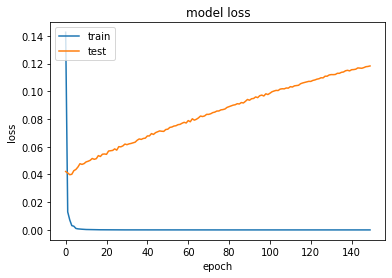

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

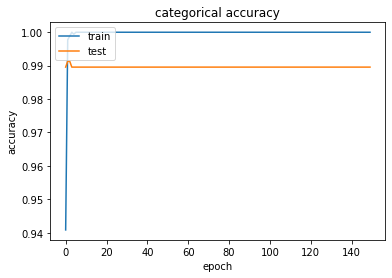

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
testy = test_labels.tolist()
predicty = predict_test.tolist()

In [1]:
##Print overall accuracy
from sklearn import metrics
# print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test))
print ("Accuracy = ", metrics.accuracy_score(testy, predicty))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, predict_test)
cm = confusion_matrix(testy, predicty)

print(cm)
# sns.heatmap(cm, annot=True)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(test_labels, predict_test))
plt.title(all_sample_title, size = 15);


NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('Classification Report')
target_names = ['Without Mask','With Mask']
print(classification_report(testy, predicty,target_names=target_names))

Classification Report
              precision    recall  f1-score   support

Without Mask       0.99      0.99      0.99       269
   With Mask       0.99      0.99      0.99       306

    accuracy                           0.99       575
   macro avg       0.99      0.99      0.99       575
weighted avg       0.99      0.99      0.99       575



Text(0.5, 1.0, 'Performance of VGG16_PCA_CNN Model')

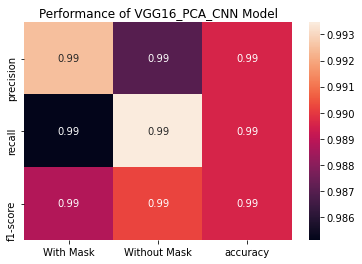

In [ ]:
import pandas as pd

clf_report = classification_report(testy, predicty , output_dict=True)
plotmap = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :3], annot=True, linecolor='black')
plt.title("Performance of VGG16_PCA_CNN Model")

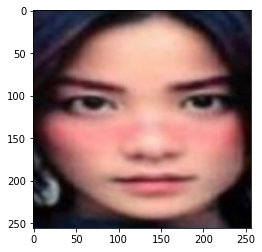

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

In [ ]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
input_img_PCA = pca.transform(input_img_features)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", test_labels[n])

The prediction for this image is:  ['Without Mask']
The actual label for this image is:  Without Mask


In [ ]:
import pickle
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/MACHINE LEARNING/modelcnn-ml.h5')

with open('/content/drive/MyDrive/MACHINE LEARNING/pcaML', 'wb') as f:
  pickle.dump(pca, f)
with open('/content/drive/MyDrive/MACHINE LEARNING/leML', 'wb') as l:
  pickle.dump(le, l)

# **Predict random image**

In [ ]:
img_path = "/content/drive/MyDrive/MACHINE LEARNING/MLDataset/train/With Mask/0_0_0 (100) (1).jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
img = cv2.resize(img, (SIZE, SIZE))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = img / 255.0

In [ ]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
input_img_PCA = pca.transform(input_img_features)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)

The prediction for this image is:  ['With Mask']
